# TRABALHO 4: Canny e Hough 

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Meta 1: Implemente uma função para detectar bordas de acordo com o algoritmo de Canny.

**Resumo do funcionamento:**
- **Filtro Espacial:** Aplica os filtros Sobel para calcular gradientes.
- **Supressão de Não Máximos:** Refina as bordas mantendo somente máximos locais.
- **Limiar Duplo:** Classifica bordas como fortes, fracas ou insignificantes.
- **Histerese:** Conecta bordas fracas próximas a bordas fortes.
- **Resultado Final:** Imagem binária com bordas detectadas.

In [ ]:
def MyCanny(image, t1, t2):  # Função para detectar bordas em uma imagem usando um algoritmo Canny
  
    def filtro_espacial(img, kernel):  # Aplica um filtro espacial (convolução) à imagem
        off = kernel.shape[0] // 2  # Calcula o offset baseado no tamanho do kernel
        filtered_image = np.zeros_like(img, dtype=float)  # Inicializa a imagem filtrada

        # Realiza a convolução
        for i in range(off, img.shape[0] - off):
            for j in range(off, img.shape[1] - off):
                I_r = img[i - off:i + off + 1, j - off:j + off + 1]  # Região correspondente ao kernel
                filtered_image[i, j] = np.sum(I_r * kernel)  # Calcula a soma ponderada

        return filtered_image
    
    # Define os kernels Sobel para detecção de gradientes nas direções X e Y
    Sy = np.array([[-1, 0, 1], 
                   [-2, 0, 2], 
                   [-1, 0, 1]])  # Gradiente Y
    Sx = Sy.T  # Gradiente X (transposta de Sy)

    # Converte a imagem para tons de cinza
    img_gs = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calcula os gradientes nas direções X e Y
    img_sy = filtro_espacial(img_gs, Sy)
    img_sx = filtro_espacial(img_gs, Sx)

    # Calcula a magnitude do gradiente
    S_norm = np.sqrt(img_sx**2 + img_sy**2)

    # Calcula a direção do gradiente em graus
    img_theta = (np.arctan2(img_sy, img_sx)) * 180 / np.pi % 180

    # Inicializa a cópia da magnitude para a supressão de não máximos
    img2 = S_norm.copy()

    # Supressão de não máximos: mantém apenas os valores máximos locais
    for i in range(1, img_theta.shape[0] - 1):
        for j in range(1, img_theta.shape[1] - 1):
            if img2[i, j] > 0:  # Se o pixel tiver um valor de gradiente significativo
                theta = img_theta[i, j]  # Obtém a direção do gradiente
                
                # Determina a orientação e compara com os vizinhos apropriados
                if 0 <= theta <= 22.5 or 157.5 <= theta <= 180:
                    if img2[i, j] <= max(img2[i-1, j], img2[i+1, j]):
                        img2[i, j] = 0  # Zera o pixel se não for máximo local
                elif 22.5 < theta <= 67.5:
                    if img2[i, j] <= max(img2[i-1, j-1], img2[i+1, j+1]):
                        img2[i, j] = 0
                elif 67.5 < theta <= 112.5:
                    if img2[i, j] <= max(img2[i, j-1], img2[i, j+1]):
                        img2[i, j] = 0
                elif 112.5 < theta < 157.5:
                    if img2[i, j] <= max(img2[i+1, j-1], img2[i-1, j+1]):
                        img2[i, j] = 0

    nms_img = img2.copy()  # Imagem após a supressão de não máximos

    # Aplicação de limiares duplos
    img_thr = np.zeros_like(nms_img)
    img_thr[nms_img >= t2] = 255  # Marca bordas fortes
    img_thr[(nms_img < t2) & (nms_img >= t1)] = 128  # Marca bordas fracas
    img_thr[nms_img < t1] = 0  # Descarta gradientes muito baixos

    # Realiza a histerese para conectar bordas
    img_hist = img_thr.copy()
    changed = True

    while changed:  # Continua enquanto houver mudanças na imagem
        changed = False
        img_copy = img_hist.copy()

        # Conecta bordas fracas a bordas fortes
        for i in range(1, img_hist.shape[0] - 1):
            for j in range(1, img_hist.shape[1] - 1):
                if img_hist[i, j] == 128:  # Verifica bordas fracas
                    I_r = img_hist[i - 1:i + 2, j - 1:j + 2]  # Vizinhança 3x3
                    if (I_r == 255).any():  # Se houver borda forte próxima
                        img_copy[i, j] = 255  # Converte em borda forte
                        changed = True

        img_hist = img_copy.copy()  # Atualiza a imagem

    # Remove bordas fracas restantes
    img_hist[img_hist == 128] = 0

    return np.uint8(img_hist)  # Retorna a imagem final como uint8


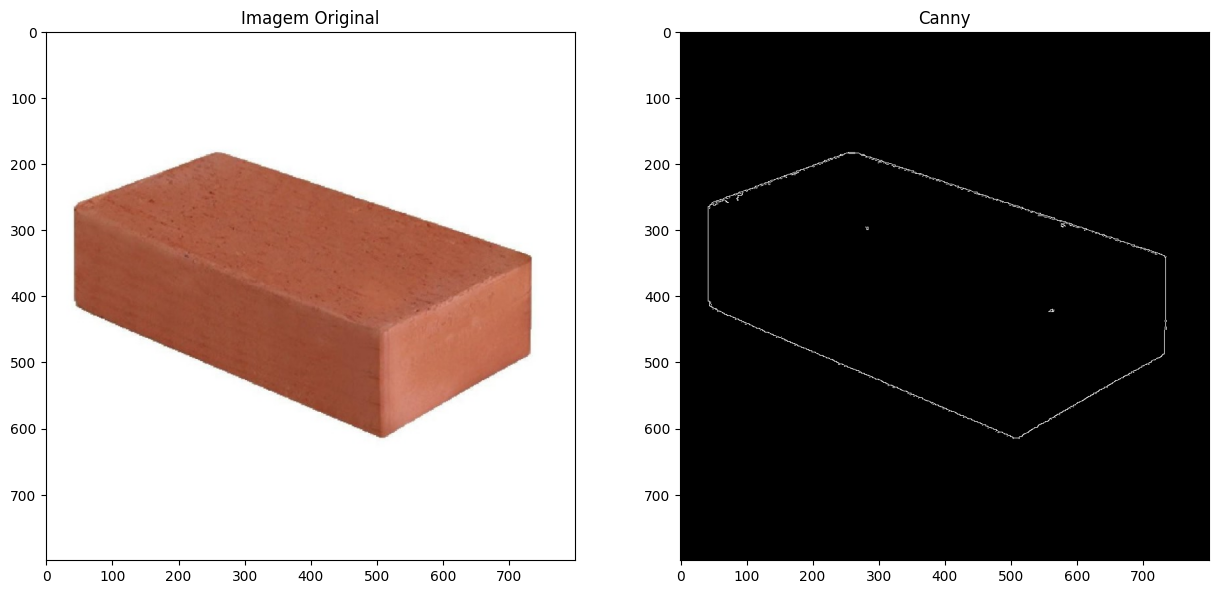

In [15]:
# Carregar a imagem do arquivo
image = cv2.imread('tijolo.jpg')

# Verificar se a imagem foi carregada corretamente
if image is None:
    raise ValueError(f'Arquivo de imagem não encontrado')

# Aplicar o detector de bordas Canny personalizado com limiares 50 e 150
edges = MyCanny(image, 50, 150)

# Configurar a visualização lado a lado: imagem original e bordas detectadas
plt.figure(figsize=(15, 7))

# Subplot para a imagem original
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Converter para RGB para exibição correta
plt.title("Imagem Original")  

# Subplot para as bordas detectadas
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))  # Converter bordas para RGB para exibição
plt.title("Canny")
plt.show()


## Meta 2: Implemente uma função para detectar linhas retas em uma imagem de acordo com o algoritmo de Hough

**Resumo do funcionamento:**

- **Transformada de Hough:** Cria um acumulador ($H$) mapeando bordas para o espaço de parâmetros ($\rho$, $\theta$).
- **Supressão de Não Máximos:** Refina o acumulador, mantendo apenas os máximos locais.
- **Seleção de Picos:** Escolhe os $n$ picos mais fortes que respeitam uma distância mínima entre si.
- **Desenho de Linhas:** Converte os picos selecionados em equações de linha e as desenha na imagem original.

In [16]:
def MyHough(image, t1, t2, n, limiar_H, min_dist=10):  
    # Implementa a Transformada de Hough para detecção de linhas em uma imagem.
    
    # Função para calcular distância esférica
    def spherical_distance(max1, max2, rho_vals, theta_vals):
        rho1, theta1 = rho_vals[max1[0]], theta_vals[max1[1]]
        rho2, theta2 = rho_vals[max2[0]], theta_vals[max2[1]]

        # Converter para coordenadas cartesianas
        x1, y1, z1 = rho1 * np.cos(theta1), rho1 * np.sin(theta1), rho1
        x2, y2, z2 = rho2 * np.cos(theta2), rho2 * np.sin(theta2), rho2

        # Distância euclidiana em 3D
        return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    
    # Detecta bordas usando a função MyCanny
    edges = MyCanny(image, t1, t2)

    # Define o espaço de parâmetros (theta e rho)
    theta = np.linspace(-np.pi, np.pi, 180)  # Ângulos de -180° a 180°
    diag = np.sqrt(edges.shape[0]**2 + edges.shape[1]**2)  # Diagonal máxima da imagem
    rho = np.linspace(-diag, diag, 1000)  # Valores de rho (distância)

    # Inicializa a matriz acumuladora de Hough (H)
    H = np.zeros((len(rho), len(theta)))

    # Preenche o acumulador Hough com os pontos de borda
    for i in range(edges.shape[0]):  
        for j in range(edges.shape[1]):
            if edges[i, j] > 0:  # Se o pixel for parte da borda
                for t_idx in range(len(theta)):  # Para cada ângulo theta
                    t = theta[t_idx]
                    r = i * np.cos(t) + j * np.sin(t)  # Calcula rho
                    r_idx = np.argmin(np.abs(rho - r))  # Encontra índice correspondente
                    H[r_idx, t_idx] += 1  # Incrementa o acumulador

    # Visualiza o acumulador H
    plt.figure(figsize=(10, 10))
    plt.imshow(H, cmap='gray', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Intensidade')
    plt.title("Visualização da Matriz H")
    plt.xlabel("Theta")
    plt.ylabel("Rho")
    plt.show()

    # Supressão de não máximos no acumulador H (janela de tamanho LxL)
    L = 29
    H_nms = np.zeros_like(H)
    offset = L // 2
    for i in range(offset, H.shape[0] - offset):
        for j in range(offset, H.shape[1] - offset):
            if H[i, j] == np.max(H[i - offset:i + offset + 1, j - offset:j + offset + 1]):
                H_nms[i, j] = H[i, j]

    # Identifica os picos em H_nms que excedem o limiar
    picos = []
    for i in range(H_nms.shape[0]):
        for j in range(H_nms.shape[1]):
            if H_nms[i, j] > limiar_H * np.max(H_nms):  # Filtra pelo limiar
                picos.append([i, j, H_nms[i, j]])

    # Ordena os picos pela intensidade em ordem decrescente
    picos.sort(key=lambda x: x[2], reverse=True)

    # Seleciona os n picos mais fortes, respeitando a distância mínima entre eles
    # Seleção dos picos usando distância esférica
    selected_peaks = []
    for pico in sorted(picos, key=lambda x: x[2], reverse=True):  # Ordenar por intensidade
        if len(selected_peaks) >= n:
            break
        if all(spherical_distance(pico[:2], selected[:2], rho, theta) >= min_dist for selected in selected_peaks):
            selected_peaks.append(pico)

    print("Picos selecionados:", len(selected_peaks))

    # Desenha as linhas correspondentes aos picos selecionados na imagem
    img_with_lines = image.copy()
    for (rho_idx, theta_idx, _) in selected_peaks:
        rho_val = rho[rho_idx]  # Converte o índice de rho em valor
        theta_val = theta[theta_idx]  # Converte o índice de theta em valor

        # Converte parâmetros polares (rho, theta) para forma cartesiana
        a = -np.cos(theta_val) / np.sin(theta_val)  # Coeficiente angular
        b = rho_val / np.sin(theta_val)  # Interseção com o eixo Y
        
        # Desenha a linha na imagem
        cv2.line(img_with_lines, (int(b), 0), (int(a * edges.shape[1] + b), edges.shape[1]), (0, 0, 255), 2)

    return img_with_lines  # Retorna a imagem com as linhas desenhadas


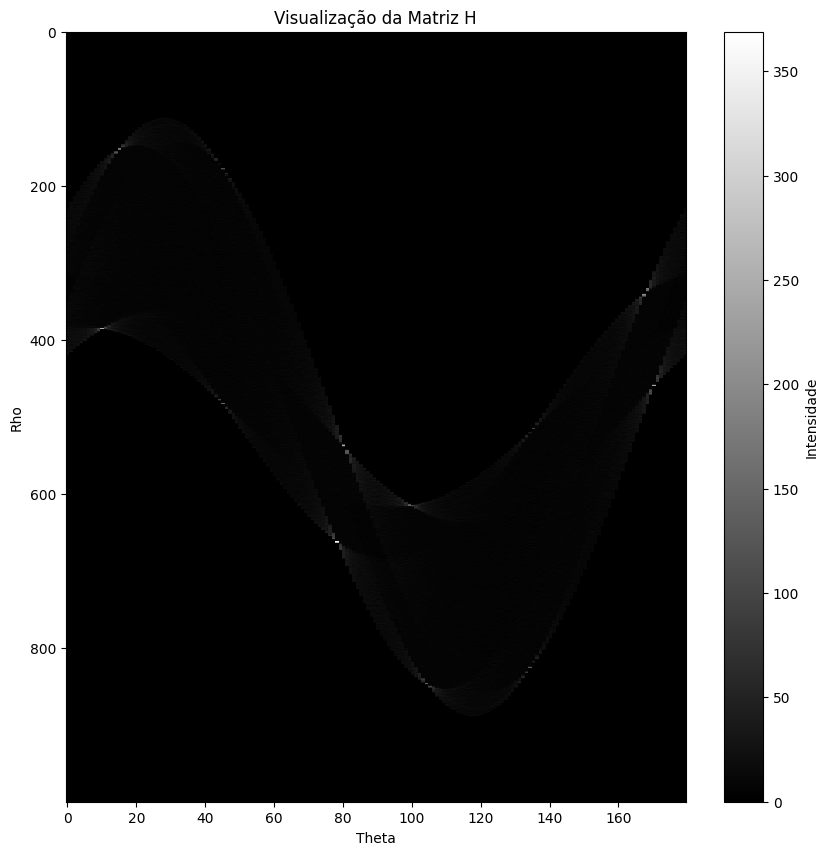

Picos selecionados: 8


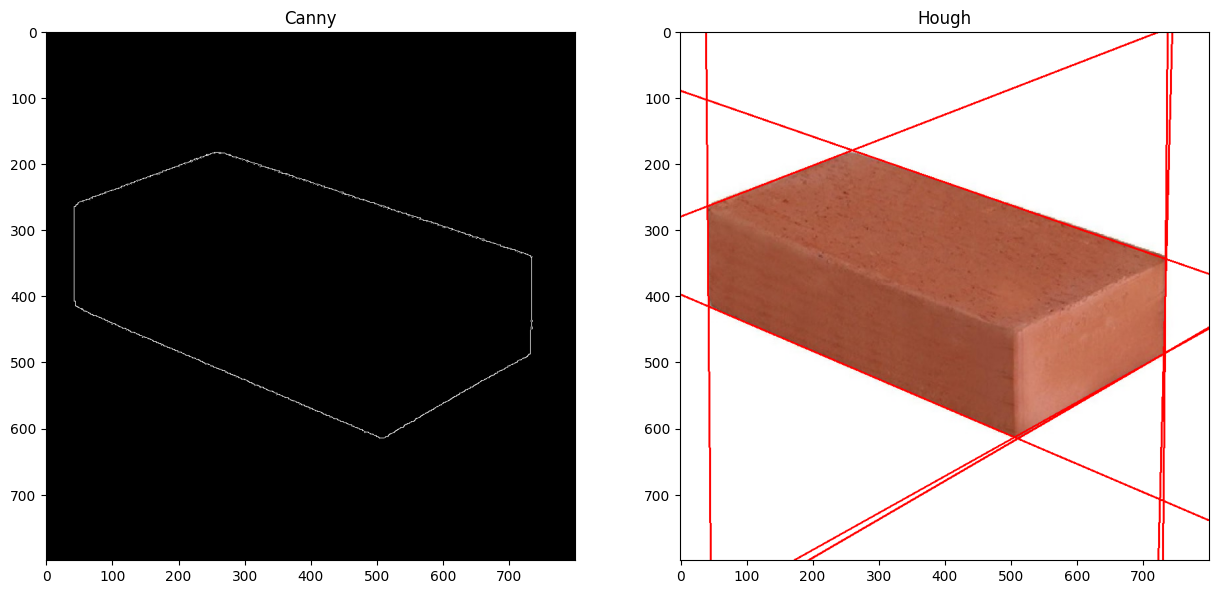

In [20]:
# Carregar a imagem do arquivo
image = cv2.imread('tijolo.jpg')

# Verificar se a imagem foi carregada corretamente
if image is None:
    raise ValueError(f'Arquivo de imagem não encontrado')

# Definir os limiares para o detector de bordas Canny
t1 = 110
t2 = 220

# Aplicar o detector de bordas Canny personalizado
edges = MyCanny(image, t1, t2)

# Aplicar a transformada de Hough para detectar linhas na imagem
H = MyHough(image, t1, t2, n=12, limiar_H=0.1, min_dist=150)

# Configurar a visualização lado a lado: bordas detectadas e transformada de Hough
plt.figure(figsize=(15, 7))

# Subplot para as bordas detectadas (Canny)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))  # Converter bordas para RGB para exibição correta
plt.title("Canny") 

# Subplot para a imagem com linhas detectadas (Hough)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(H, cv2.COLOR_BGR2RGB))  # Converter resultado de Hough para RGB para exibição
plt.title('Hough') 
plt.show()


Não consegui tratar essas multiplas retas nos mesmos pontos.